# Library

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
import os
import math
import json
import re
import tensorflow as tf


import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"
# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

# Data

#### Character To Ordinal Encoding

In [18]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

# Character to Ordinal Encoding Mapping
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))
N_UNIQUE_CHARACTERSPAD_TOKEN = len(CHAR2ORD)
SOS_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


In [19]:
# Read Train DataFrame
df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
# Number Of Train Samples
N_SAMPLES = len(df)
print(f'N_SAMPLES: {N_SAMPLES}')
display(df.head())

N_SAMPLES: 67208


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [20]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/train_landmarks/{path}'

df['file_path'] = df['path'].apply(get_file_path)

In [21]:
# Split Phrase To Char Tuple
df['phrase_char'] = df['phrase'].apply(tuple)
# Character Length of Phrase
df['phrase_char_len'] = df['phrase_char'].apply(len)
# Maximum Input Length
MAX_PHRASE_LENGTH = df['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = df.set_index('sequence_id')

MAX_PHRASE_LENGTH: 31


In [22]:
df

,path,file_id,sequence_id,participant_id,phrase,file_path,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25
...,...,...,...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913,/kaggle/input/asl-fingerspelling/train_landmar...,"(4, 3, 1, -, 3, 6, 6, -, 2, 9, 1, 3)",12
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850,/kaggle/input/asl-fingerspelling/train_landmar...,"(9, 9, 4, -, 3, 9, 2, -, 3, 8, 5, 0)",12
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com,/kaggle/input/asl-fingerspelling/train_landmar...,"(h, t, t, p, s, :, /, /, w, w, w, ., t, i, a, ...",30
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle,/kaggle/input/asl-fingerspelling/train_landmar...,"(9, 0, , k, e, r, w, o, o, d, , c, i, r, c, ...",17


#### Character Distribution

In [23]:
# Select the 'phrase_char_len' column from the DataFrame
phrase_len_column = df['phrase_char_len']

# Calculate the sum of values in the 'phrase_char_len' column
total_phrase_char_len = phrase_len_column.sum()

# Print the total sum in the 'phrase_char_len' column
print("Total characters in dataset", total_phrase_char_len)

Total characters in dataset 1196614


In [24]:

# Select the 'phrase_char' column from the DataFrame
phrase_column = df['phrase_char']

# Initialize variables to count letters and digits
count_letters = 0
count_digits = 0

# Iterate through each row in the 'phrase_char' column
for row in phrase_column:
    # Remove parentheses at the beginning and end, then split by ', '
    row = str(row).strip("()").split(', ')
    
    for phrase in row:
        for char in phrase:
            if char.isalpha():
                # If the character is a letter, increase the letter count by 1
                count_letters += 1
            elif char.isdigit():
                # If the character is a digit, increase the digit count by 1
                count_digits += 1

# Calculate the count of special characters
count_special_characters = total_phrase_char_len - count_letters - count_digits

# Print the counts of letters, digits, and special characters
print("Number of letters:", count_letters)
print("Number of digits:", count_digits)
print("Number of special characters:", count_special_characters)


Number of letters: 732568
Number of digits: 294261
Number of special characters: 169785


In [25]:
# Calculate the percentage of letters, digits, and special characters
percentage_letters = (count_letters / total_phrase_char_len) * 100
percentage_digits = (count_digits / total_phrase_char_len) * 100
percentage_special_characters = (count_special_characters / total_phrase_char_len) * 100


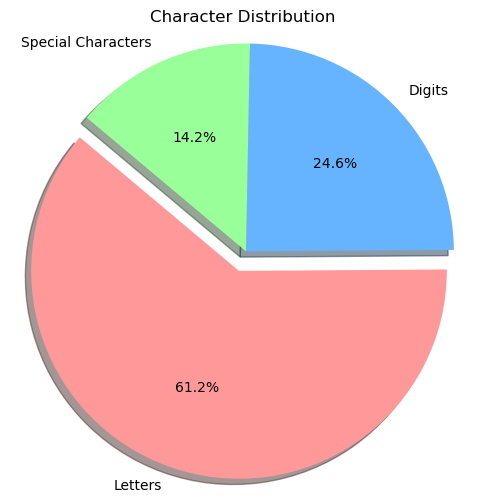

In [26]:
import matplotlib.pyplot as plt

# Total character count
total_phrase_len = count_letters + count_digits + count_special_characters

# Calculate the percentage for each type of character
percentage_letters = (count_letters / total_phrase_len) * 100
percentage_digits = (count_digits / total_phrase_len) * 100
percentage_special_characters = (count_special_characters / total_phrase_len) * 100

# Data for the pie chart
labels = 'Letters', 'Digits', 'Special Characters'
sizes = [percentage_letters, percentage_digits, percentage_special_characters]
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Colors
explode = (0.1, 0, 0)  # To create an "explode" effect for the "Letters" segment

# Create the pie chart
plt.figure(figsize=(6, 6))  # Chart size
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Ensure the pie chart is a perfect circle
plt.title("Character Distribution")  # Chart title

# Display the chart
plt.show()


In [27]:
# Read First Parquet File
parquet_df = pd.read_parquet(str('/kaggle/input/asl-fingerspelling/')+df['path'][0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {parquet_df.index.nunique()}')
# Display DataFrame layout
display(parquet_df.head())

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering

In [28]:
"""
Attempt to retrieve phrase type
Could be used for pretraining or type specific inference
 *) Phone Number\
 *) URL
 *3) Addres
"""
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
df['phrase_type'] = df['phrase'].apply(get_phrase_type)

# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'
df['file_path'] = df['path'].apply(get_file_path)

# Get phrase character to Character Tuple
def get_char_tuple(phrase):
    return tuple(phrase)
df['phrase_char'] = df['phrase'].apply(get_char_tuple)

# Get Character Tuple Length
def get_char_tuple_len(c):
    return len(c)
df['phrase_char_len'] = df['phrase_char'].apply(get_char_tuple_len)

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
df_sequence_id = df.set_index('sequence_id')

## Descriptive Statistic

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             67208 non-null  object
 1   file_id          67208 non-null  int64 
 2   sequence_id      67208 non-null  int64 
 3   participant_id   67208 non-null  int64 
 4   phrase           67208 non-null  object
 5   file_path        67208 non-null  object
 6   phrase_char      67208 non-null  object
 7   phrase_char_len  67208 non-null  int64 
 8   phrase_type      67208 non-null  object
dtypes: int64(4), object(5)
memory usage: 4.6+ MB


In [30]:
df.describe()

,file_id,sequence_id,participant_id,phrase_char_len
count,6.720800e+04,6.720800e+04,67208.000000,67208.000000
mean,1.094448e+09,1.072696e+09,119.758154,17.804636
std,6.395616e+08,6.177372e+08,74.330468,5.727504
min,5.414471e+06,7.109500e+04,0.000000,1.000000
25%,5.277082e+08,5.376519e+08,63.000000,12.000000
50%,1.099408e+09,1.074387e+09,113.000000,17.000000
75%,1.662743e+09,1.605592e+09,178.000000,22.000000
max,2.118949e+09,2.147465e+09,254.000000,31.000000


In [31]:
# Number of parquet chunks to analyse
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
SEED = 42

global parquet_df

N = 5 if IS_INTERACTIVE else 25
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(df['file_path'].unique())

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    parquet_df = pd.read_parquet(file_path)
    for group, group_df in parquet_df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

# Number of unique frames in each video
PERCENTILES = [0.01, 0.10, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('Value').astype(int))

  0%|          | 0/5 [00:00<?, ?it/s]

,Value
count,4996
mean,160
std,83
min,1
1%,6
5%,36
10%,68
25%,104
50%,150
75%,206


(0.0, 752.0)

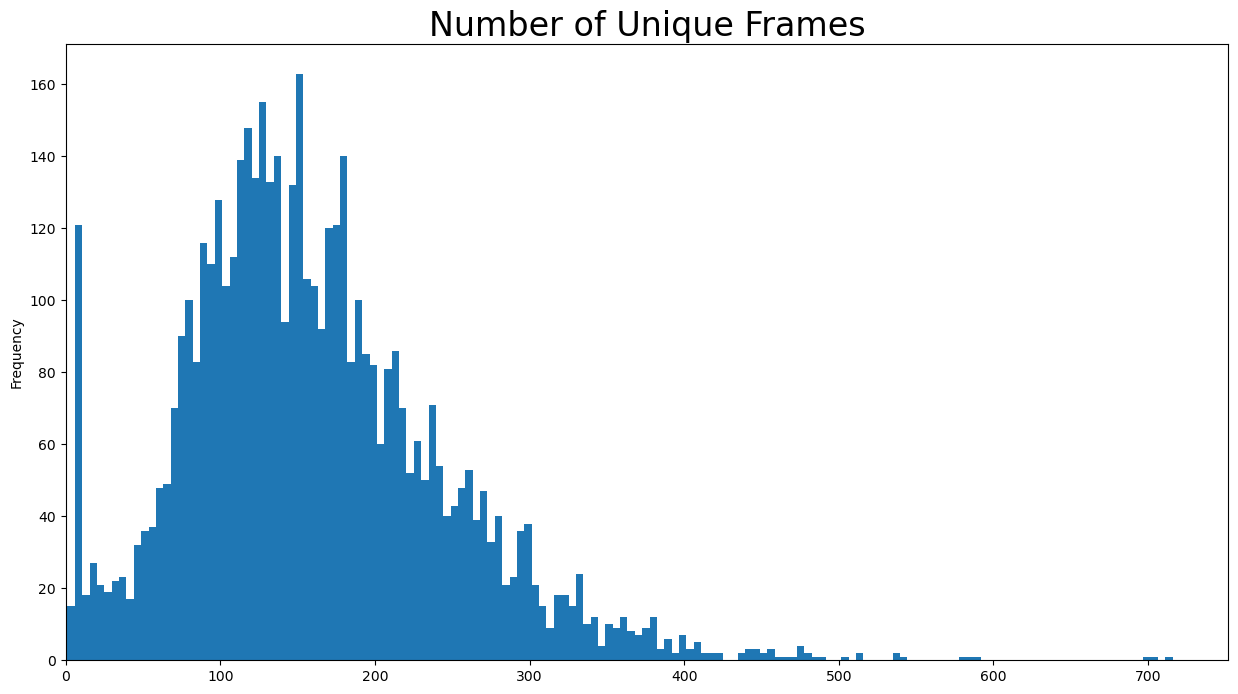

In [32]:
plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size = 24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist',bins=150)
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)


## Data Visualization

In [33]:
# Number of unique characters
UNIQUE_CHARACTERS = np.unique(np.concatenate(df['phrase_char']))
N_UNIQUE_CHARACTERS = len(UNIQUE_CHARACTERS)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

N_UNIQUE_CHARACTERS: 59


In [34]:
# Count the number of occurrences of each fruit
counts = df['phrase_type'].value_counts()

# Create a pie chart using plotly.express
fig = px.pie(counts, values=counts.values, names=counts.index)

# Show the pie chart
fig.show()

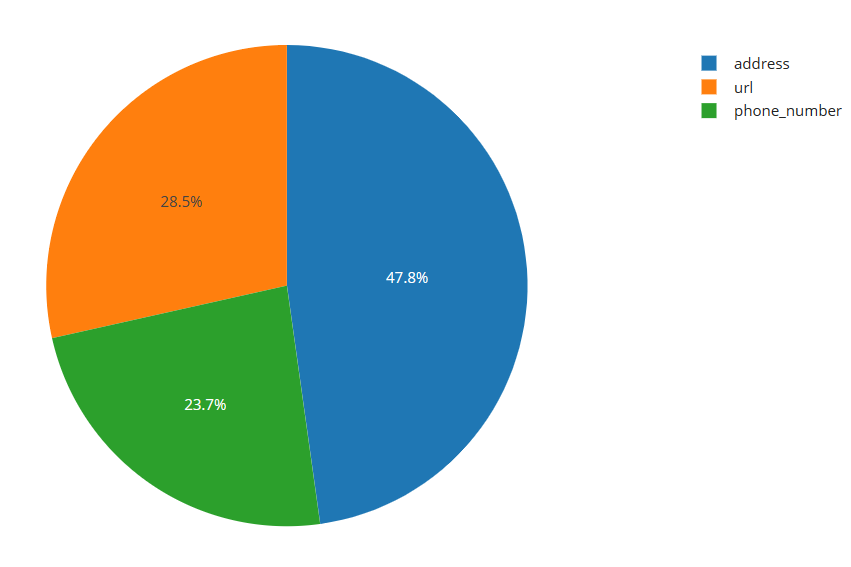

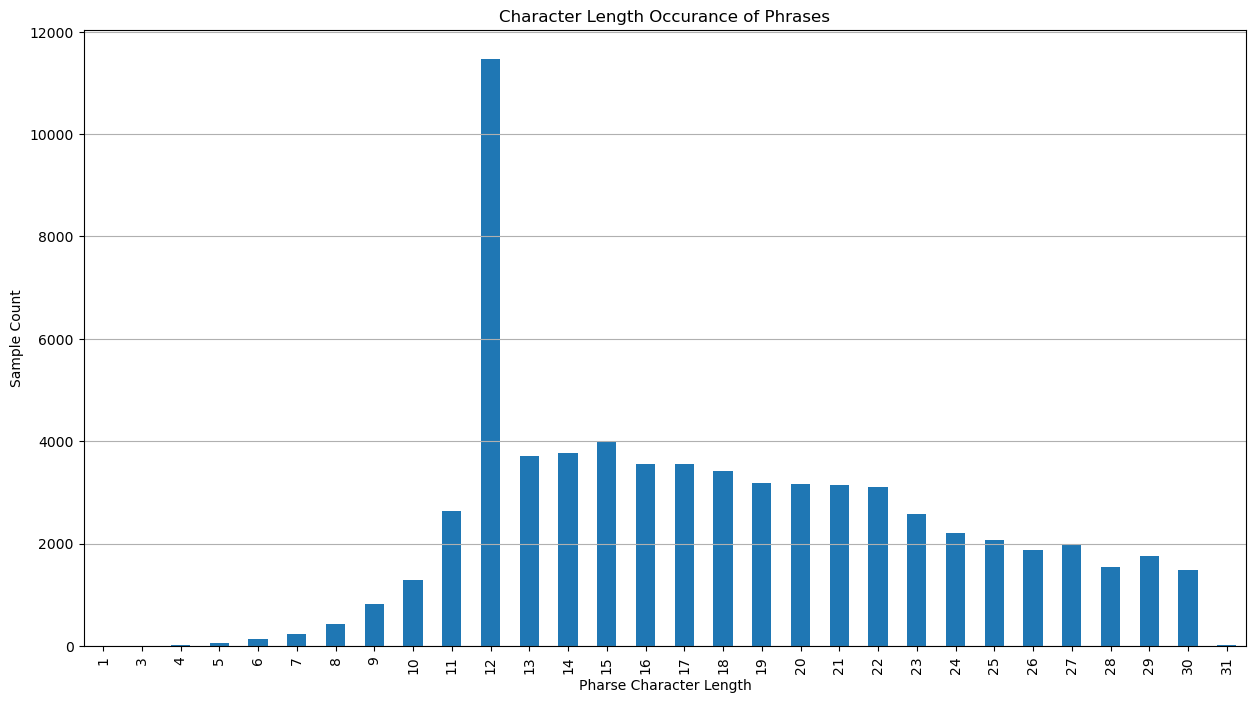

In [35]:
# Character Count Occurance
plt.figure(figsize=(15,8))
plt.title('Character Length Occurance of Phrases')
df['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, df['phrase_char_len'].max() - 1.50)
plt.xlabel('Pharse Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

In [36]:
print(f'Number of parquet files:{len(df["path"].unique())}')
print(f'Number of phrase : {len(df["phrase"].unique())}')
print(f'Number of sequence id: {len(df["sequence_id"].unique())}')

Number of parquet files:68
Number of phrase : 46478
Number of sequence id: 67208


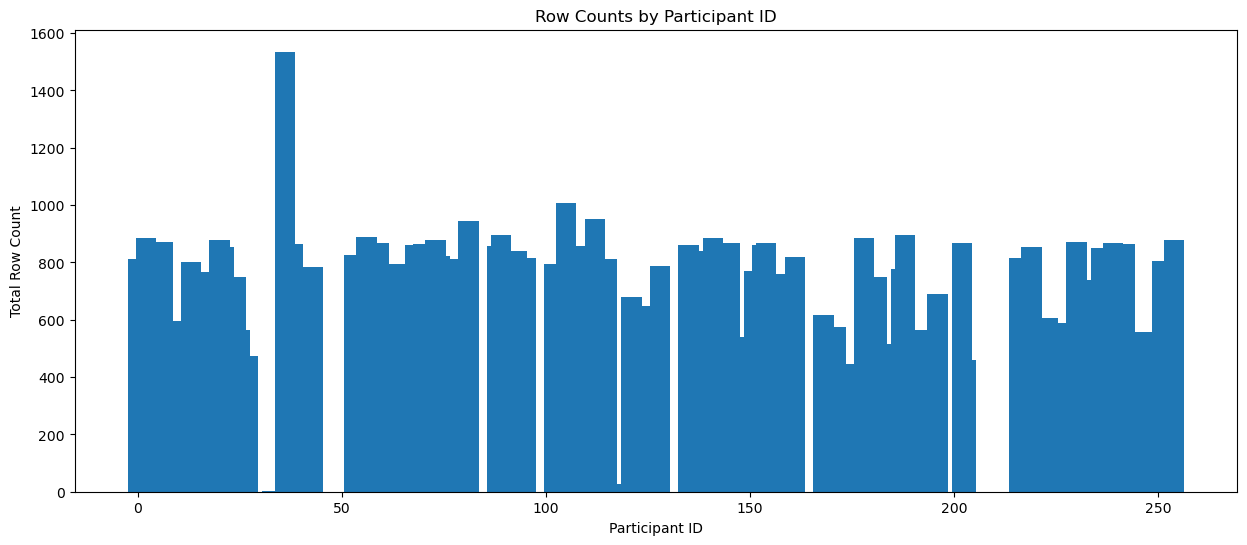

In [37]:
# Calculate the counts for each participant_id
counts = df["participant_id"].value_counts()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the histogram
bars = ax.bar(counts.index, counts.values,width=5)

# Set the labels and title
ax.set_xlabel("Participant ID")
ax.set_ylabel("Total Row Count")
ax.set_title("Row Counts by Participant ID")

# Show the plot
plt.show()

 ## Count of each character

In [38]:
import plotly.graph_objects as go
character_count = {}
for phrase in df["phrase"]:
    for char in phrase:
        try:
            character_count[char] += 1
        except KeyError:
            character_count[char] = 1
character_count = dict(sorted(character_count.items(), key=lambda k: k[1], reverse=True))
fig = go.Figure(
    data=[
        go.Bar(
            x=list(character_count.keys()),
            y=list(character_count.values()),
            hovertemplate='Character: <b>%{x}</b><br>Count: <b>%{y}</b><extra></extra>'
        )
    ]
)
fig.update_traces(
    marker_color='rgb(158,202,225)',
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5,
)
fig.update_layout(
    title={
        'text':f'<b>Count of each character</b>',
        'y':0.95,
        'x':0.5,
        'xanchor':'center',
        'yanchor':'top'
    },
    xaxis_title="Character",
    yaxis_title="Count",
    height=500,
    title_x=0.5,
    hoverlabel=dict(
        font_size=14,
    ),
    title_font_size=24,
    template="plotly_white",
    margin=dict(t=40,b=20,l=20,r=20),
    yaxis_tickformat='digits',
    margin_pad=5
)
fig.show()

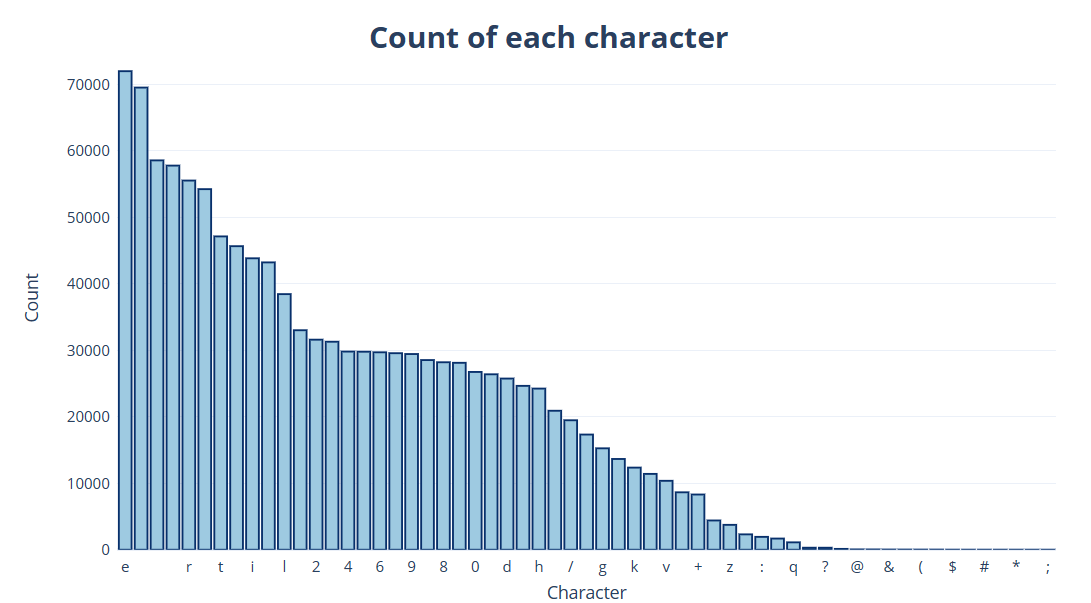

In [39]:
parquet_df[parquet_df.index==165414438]

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
165414438,0,0.304002,0.309166,0.307179,0.299756,0.309943,0.310351,0.310548,0.226290,0.311064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165414438,1,0.305725,0.310174,0.308111,0.300651,0.310920,0.311288,0.311370,0.226966,0.311819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165414438,2,0.310209,0.310440,0.308666,0.300716,0.311051,0.311325,0.311305,0.228599,0.311701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165414438,3,0.313267,0.312775,0.311140,0.302551,0.313253,0.313327,0.312905,0.228463,0.313018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165414438,4,0.314100,0.313528,0.311932,0.302463,0.313813,0.313522,0.312406,0.229410,0.312100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165414438,165,0.334148,0.331948,0.329604,0.321389,0.332480,0.332235,0.330852,0.245265,0.330642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165414438,166,0.332546,0.331612,0.329266,0.320913,0.332138,0.331867,0.330416,0.245284,0.330171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165414438,167,0.330804,0.330504,0.328247,0.319552,0.330929,0.330545,0.328873,0.244433,0.328507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
from plotly.subplots import make_subplots
# Loop over all parquet files and collect data
frames = {} # Save total frames as a dict
file_list = df["path"].unique() # List of files
for index, path in enumerate(file_list):
    a = parquet_df # read the corresponding parquet file into a dataframe
    frame_count = a.groupby(a.index)["frame"].count().tolist() # count the number of frames and store into an array
    frames[path.split("/")[1].split(".")[0]] = frame_count # parse the label for the file
def plot_frame_distribution(frames):
    fig = make_subplots(
        rows=1,
        cols=1,  # Số cột giảm xuống 1
        horizontal_spacing=0.01
    )

    for key in frames.keys():
        trace1 = go.Scatter(
            y=frames[key],
            name=key,
            hovertemplate='Sequence Number: <b>%{x}</b><br>Number of frames: <b>%{y}</b><extra></extra>',
            marker_color='#484bfa',
            opacity=0.75,
        )
        fig.add_trace(trace1)
    length_of_data = len(fig.data)
    length_of_frames = len(frames.keys())
    for data in range(1, length_of_data):
        fig.update_traces(visible=False, selector=data)
    fig.show()
plot_frame_distribution(frames)


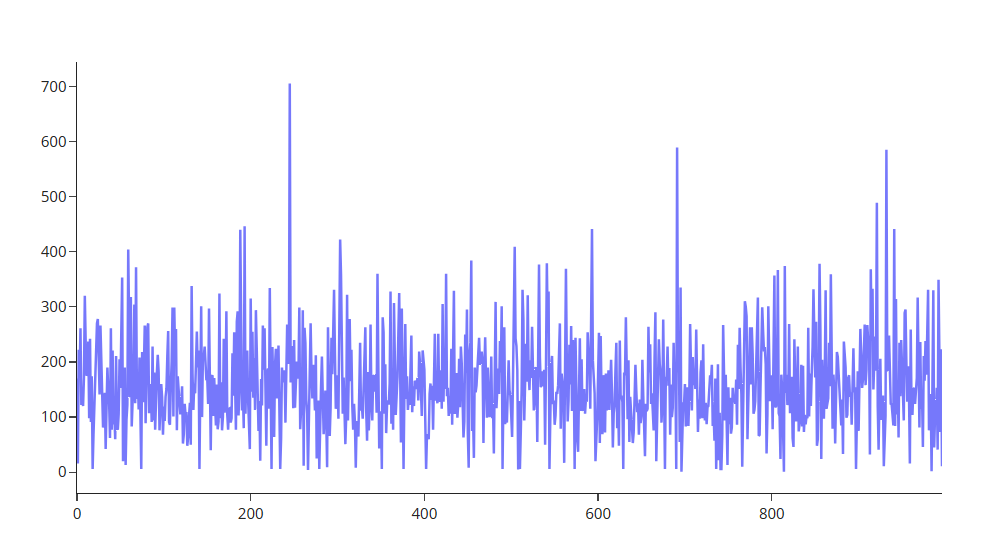

Text(0, 0.5, 'Sample Count')

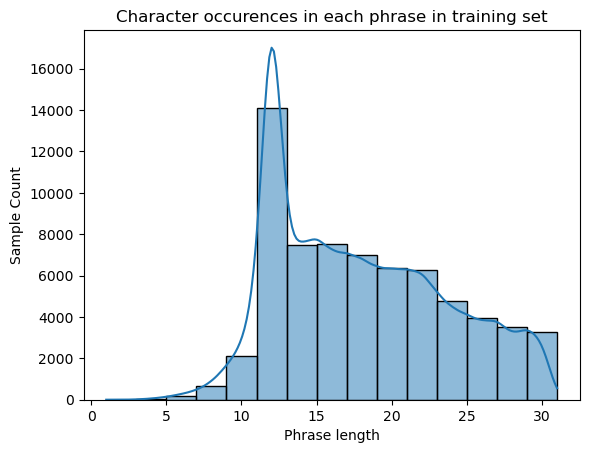

In [41]:
df['phrase_len'] = df.phrase.str.len()
sns.histplot(df.phrase_len, kde=True, binwidth = 2)
plt.title('Character occurences in each phrase in training set')
plt.xlabel('Phrase length')
plt.ylabel('Sample Count')

  0%|          | 0/401 [00:00<?, ?it/s]

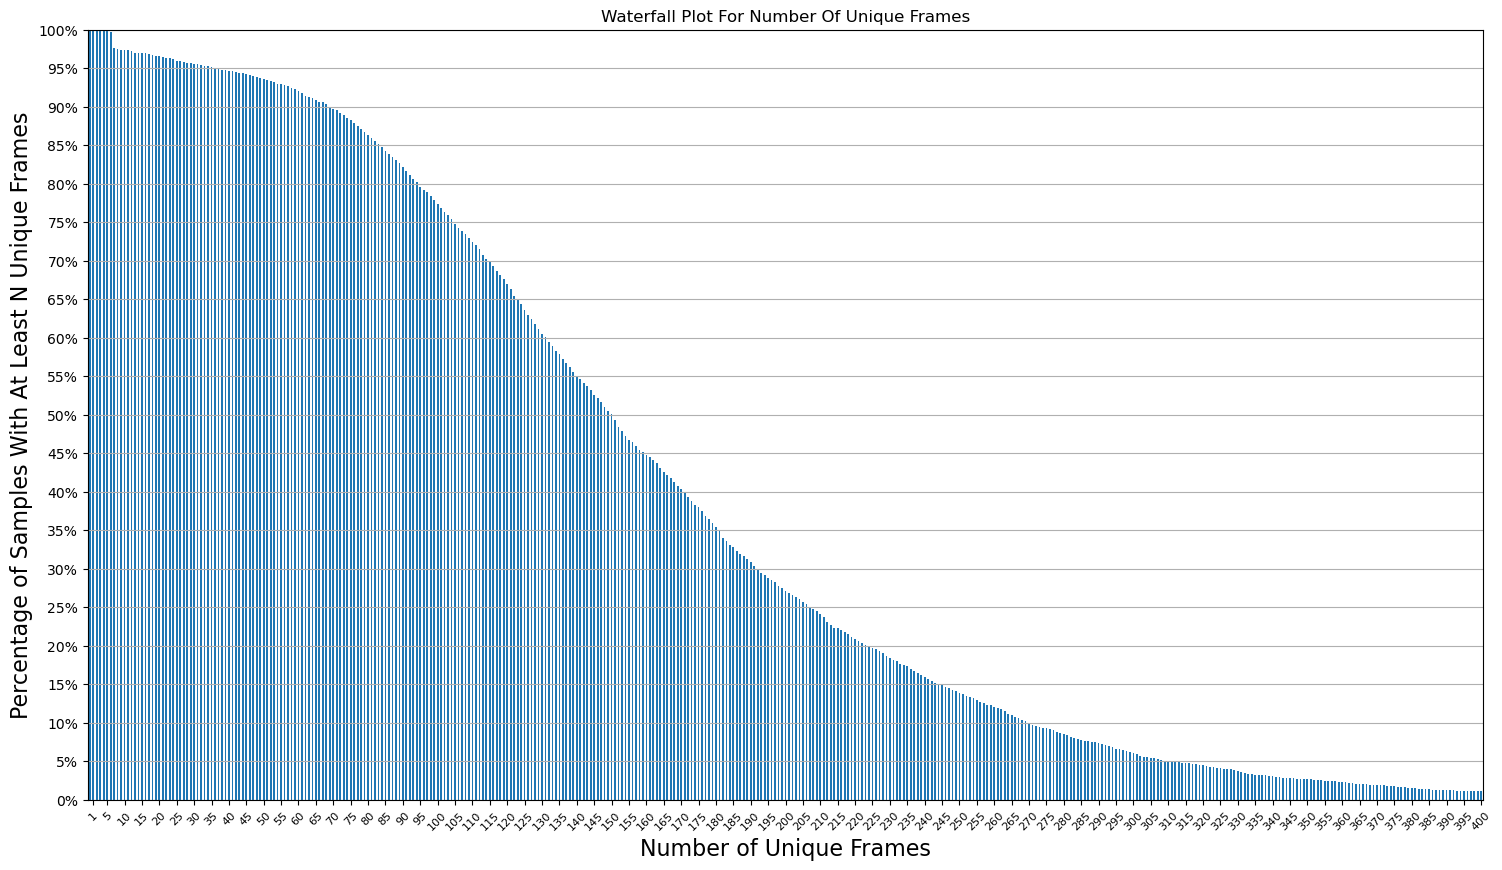

In [42]:
# With N_TARGET_FRAMES = 256 ~85% will be below
N_UNIQUE_FRAMES_WATERFALL = []
# Maximum Number of Unique Frames to use
N_MAX_UNIQUE_FRAMES = 400
# Compute Percentage
for n in tqdm(range(0,N_MAX_UNIQUE_FRAMES+1)):
    N_UNIQUE_FRAMES_WATERFALL.append(sum(N_UNIQUE_FRAMES >= n) / len(N_UNIQUE_FRAMES) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Unique Frames')
pd.Series(N_UNIQUE_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks([1] + np.arange(5, N_MAX_UNIQUE_FRAMES+5, 5).tolist(), size=8, rotation=45)
plt.xlabel('Number of Unique Frames', size=16)
plt.yticks(np.arange(0, 100+5, 5), [f'{i}%' for i in range(0,100+5,5)])
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Unique Frames', size=16)
plt.show()

## Landmark Indices

In [43]:
def get_idxs(parquet_df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [44]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [45]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [46]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

## Visualize Sequence

In [47]:
def map_new_to_old_style(sequence):
    types = []
    landmark_indexes = []
    for column in list(sequence.columns)[1:544]:
        parts = column.split("_")
        if len(parts) == 4:
            types.append(parts[1] + "_" + parts[2])
        else:
            types.append(parts[1])

        landmark_indexes.append(int(parts[-1]))

    data = {
        "frame": [],
        "type": [],
        "landmark_index": [],
        "x": [],
        "y": [],
        "z": []
    }

    for index, row in sequence.iterrows():
        data["frame"] += [int(row.frame)]*543
        data["type"] += types
        data["landmark_index"] += landmark_indexes

        for _type, landmark_index in zip(types, landmark_indexes):
            data["x"].append(row[f"x_{_type}_{landmark_index}"])
            data["y"].append(row[f"y_{_type}_{landmark_index}"])
            data["z"].append(row[f"z_{_type}_{landmark_index}"])

    return pd.DataFrame.from_dict(data)

# assign desired colors to landmarks
def assign_color(row):
    if row == 'face':
        return 'red'
    elif 'hand' in row:
        return 'dodgerblue'
    else:
        return 'green'

# specifies the plotting order
def assign_order(row):
    if row.type == 'face':
        return row.landmark_index + 101
    elif row.type == 'pose':
        return row.landmark_index + 30
    elif row.type == 'left_hand':
        return row.landmark_index + 80
    else:
        return row.landmark_index

def visualise2d_landmarks(parquet_df, title=""):
    connections = [
        [0, 1, 2, 3, 4,],
        [0, 5, 6, 7, 8],
        [0, 9, 10, 11, 12],
        [0, 13, 14, 15, 16],
        [0, 17, 18, 19, 20],


        [38, 36, 35, 34, 30, 31, 32, 33, 37],
        [40, 39],
        [52, 46, 50, 48, 46, 44, 42, 41, 43, 45, 47, 49, 45, 51],
        [42, 54, 56, 58, 60, 62, 58],
        [41, 53, 55, 57, 59, 61, 57],
        [54, 53],


        [80, 81, 82, 83, 84, ],
        [80, 85, 86, 87, 88],
        [80, 89, 90, 91, 92],
        [80, 93, 94, 95, 96],
        [80, 97, 98, 99, 100], ]

    parquet_df = map_new_to_old_style(parquet_df)
    frames = sorted(set(parquet_df.frame))
    first_frame = min(frames)
    parquet_df['color'] = parquet_df.type.apply(lambda row: assign_color(row))
    parquet_df['plot_order'] = parquet_df.apply(lambda row: assign_order(row), axis=1)
    first_frame_df = parquet_df[parquet_df.frame == first_frame].copy()
    first_frame_df = first_frame_df.sort_values(["plot_order"]).set_index('plot_order')


    frames_l = []
    for frame in frames:
        filtered_df = parquet_df[parquet_df.frame == frame].copy()
        filtered_df = filtered_df.sort_values(["plot_order"]).set_index("plot_order")
        traces = [go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color=filtered_df.color,
                size=9))]

        for i, seg in enumerate(connections):
            trace = go.Scatter(
                    x=filtered_df.loc[seg]['x'],
                    y=filtered_df.loc[seg]['y'],
                    mode='lines',
            )
            traces.append(trace)
        frame_data = go.Frame(data=traces, traces = [i for i in range(17)])
        frames_l.append(frame_data)

    traces = [go.Scatter(
        x=first_frame_df['x'],
        y=first_frame_df['y'],
        mode='markers',
        marker=dict(
            color=first_frame_df.color,
            size=9
        )
    )]
    for i, seg in enumerate(connections):
        trace = go.Scatter(
            x=first_frame_df.loc[seg]['x'],
            y=first_frame_df.loc[seg]['y'],
            mode='lines',
            line=dict(
                color='black',
                width=2
            )
        )
        traces.append(trace)
    fig = go.Figure(
        data=traces,
        frames=frames_l
    )


    fig.update_layout(
        width=500,
        height=800,
        scene={
            'aspectmode': 'data',
        },
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, {"frame": {"duration": 100,
                                                  "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {"duration": 0}}],
                        "label": "&#9654;",
                        "method": "animate",
                    },

                ],
                "direction": "left",
                "pad": {"r": 100, "t": 100},
                "font": {"size":30},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
    )
    camera = dict(
        up=dict(x=0, y=-1, z=0),
        eye=dict(x=0, y=0, z=2.5)
    )
    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_layout(scene_camera=camera, showlegend=False)
    fig.update_layout(xaxis = dict(visible=False),
            yaxis = dict(visible=False),
    )
    fig.update_yaxes(autorange="reversed")

    fig.show()


def get_phrase(df, file_id, sequence_id):
    return df[
        np.logical_and(
            df.file_id == file_id,
            df.sequence_id == sequence_id
        )
    ].phrase.iloc[0]

In [48]:
sequence_id = 1817123330
file_id = 5414471

In [49]:
path_to_sign = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
sign = pd.read_parquet(path_to_sign)
sequence = sign[sign.index == sequence_id]

In [ ]:
sequence_phrase = get_phrase(df, file_id, sequence_id)
visualise2d_landmarks(sequence, f"Phrase: {sequence_phrase}")

## Data Cleaning

In [ ]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayerNonNaN(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayerNonNaN, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer_non_nan = PreprocessLayerNonNaN()

In [ ]:
# Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(df['file_path'].unique())
# Number of parquet chunks to analyse
N = 5 if (IS_INTERACTIVE or FAST) else len(UNIQUE_FILE_PATHS)
# Number of Non Nan Frames in Recording
N_NON_NAN_FRAMES = []

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    parquet_df = pd.read_parquet(file_path)
    for group, group_df in parquet_df.groupby('sequence_id'):
        frames = preprocess_layer_non_nan(group_df[COLUMNS0].values).numpy()
        N_NON_NAN_FRAMES.append(len(frames))

# Convert to Numpy Array
N_NON_NAN_FRAMES = pd.Series(N_NON_NAN_FRAMES).to_frame('# Frames')

In [ ]:
N_NON_NAN_FRAMES.plot(kind='hist', bins=128, figsize=(15,8))
plt.title('Number of Non NaN Frames', size=24)
plt.grid()
xlim = np.percentile(N_NON_NAN_FRAMES, 99)
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+32, 32))
plt.show()


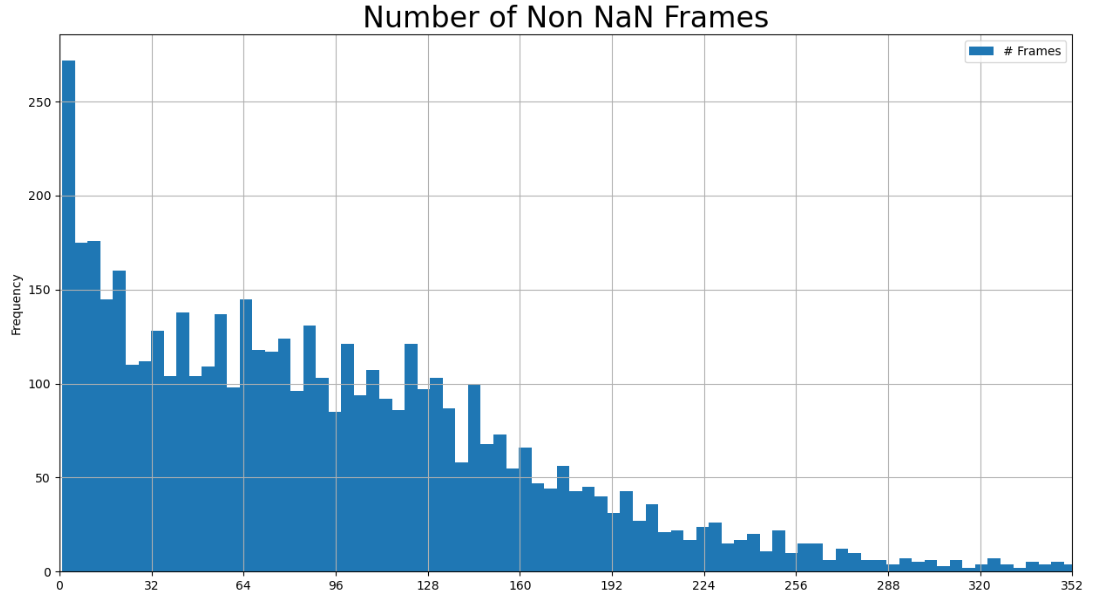